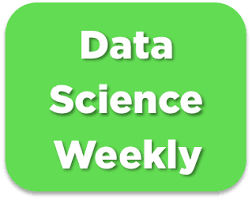

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import  -  Load  -  Explore

In [1]:
####
# Import base
# ######
import time
import pandas as pd
import numpy as np
####
# sklearn utils
# ######
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
####
# sklearn classifiers
# ######
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
####
# Graphic libs
# ######
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "vscode" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [3]:
####
# Load
# ######
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)
data.head()

####
# Explore
# ######
print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

Set with labels (our train+test) : (284580, 6)
Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

/var/folders/zq/g6yc8mlj3n15tzbmsqkbdqc00000gn/T/ipykernel_56472/2202920383.py:18: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,age,new_user,total_pages_visited,converted
age,1.00,0.01,-0.05,-0.09
new_user,0.01,1.00,-0.08,-0.15
total_pages_visited,-0.05,-0.08,1.00,0.53
converted,-0.09,-0.15,0.53,1.00


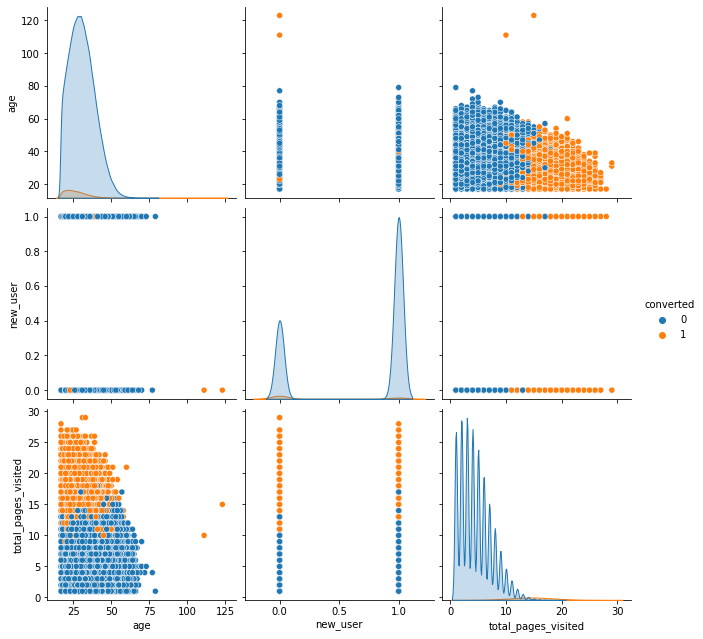

In [4]:
sns.pairplot(data, hue='converted', height=3)

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

## 1. Remove outliers

In [5]:
outliers_col = ['age']
before = data.shape[0]
print('About to remove outliers : ... ', end=" ")
for col in outliers_col:
    to_keep = np.abs(data[col]-data[col].mean()) <= (3*data[col].std())
    data = data.loc[to_keep,:]

print('done removing outlier, {} rows removed.'.format(before - data.shape[0]))
data.head()

About to remove outliers : ...  done removing outlier, 1017 rows removed.


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## 2 Drop, split, Pipeline & etc

In [13]:
###
# Let's have a peek at the baseline
########
(data['converted'].value_counts()/data.shape[0])*100

0    96.765093
1     3.234907
Name: converted, dtype: float64

In [6]:
target_variable = 'converted'
data = data.dropna(subset = [target_variable])

label_num = ['age', 'total_pages_visited']
label_cat = ['country', 'new_user', 'source']

X = data.loc[:, label_num+label_cat]
Y = data.loc[:, target_variable]

num_features_idx = [X.columns.tolist().index(a) for a in label_num]
cat_features_idx = [X.columns.tolist().index(a) for a in label_cat]

# Divide dataset Train set & Test set 
print("Dividing into train and test sets... ", end=" ")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)
print("done.")

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays... ", end= " ")
X_train, Y_train = X_train.values, Y_train.values
X_test, Y_test = X_test.values, Y_test.values
print("done")

# Preprocessings
print("Encoding categorical features and standardizing numerical features... ", end=" ")

# Create pipeline for numeric features
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create pipeline for categorical features
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features_idx),
        ('cat', cat_transformer, cat_features_idx)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(" done")

Dividing into train and test sets...  done.
Convert pandas DataFrames to numpy arrays...  done
Encoding categorical features and standardizing numerical features...   done


In [7]:

dict = [
    #{
    #'classifier' : 'LogisticRegression',
    #'init_params': "multi_class='auto', solver='liblinear', penalty='l1'",
    #'best_params': "C=1.8329807108324339, multi_class='auto', solver='liblinear', penalty='l1'",
    #'grid_params': "{'C':np.logspace(-5, 5, 20)}",   
    #},
    #{
    #'classifier' : 'DecisionTreeClassifier',
    #'init_params': "",
    #'best_params': "criterion='gini', ccp_alpha=1e-05",
    #'grid_params': "{'ccp_alpha':np.logspace(0, -5, 20), 'criterion':['gini', 'entropy']}",
    #},
    #{
    #'classifier' : 'RandomForestClassifier',
    #'init_params': 'n_jobs=-1',
    #'best_params': 'n_jobs=-1, max_depth=4, min_samples_split=2, n_estimators=31',
    #'grid_params': "{'max_depth': np.arange(2,5), 'n_estimators': np.arange(20,40), 'min_samples_split': np.arange(2, 4)}",
    #},
  # Too long !!!!!
    # {
    #'classifier' : 'SVC',
    #'init_params': '',
    #'best_params': "C=1, gamma=0.0001, kernel='linear'",
    #'grid_params': "{'C': [1, 5, 10, 50],'gamma': [0.0001, 0.0005, 0.001, 0.005], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}",
    #},
    #{
    #'classifier' : 'AdaBoostClassifier',
    #'init_params': '',
    #'best_params': 'learning_rate=1.0, n_estimators=150',
    #'grid_params': "{'n_estimators':[50, 100, 150, 200],'learning_rate':[1.0, 0.5, 0.1]}",
    #},
    {
    'classifier' : 'XGBClassifier',
    'init_params': "n_jobs=-1, use_label_encoder=False, eval_metric='merror', 'objective': 'binary:logistic'",
    # {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50}
    # 0.763384	0.76993	226850	56713	2.772499
    'best_params': "objective='binary:logistic', gamma=0.3, n_jobs=-1, learning_rate=0.1, max_depth=4, n_estimators=100, use_label_encoder=False, eval_metric='merror'",
    'grid_params': "{'max_depth': [3,4,5], 'n_estimators':[50, 100, 150, 200],'learning_rate':[1.0, 0.5, 0.1], 'gamma':[i/10.0 for i in range(0,5)] }",
    },
    #{
    #'classifier' : 'GradientBoostingClassifier',
    #'init_params': "",
    #'best_params': "learning_rate=0.1, max_depth=5, n_estimators=50",
    #'grid_params': "{'max_depth': [3,4,5], 'n_estimators':[50, 100, 150, 200],'learning_rate':[1.0, 0.5, 0.1], criterion=['friedman_mse','squared_error']}",
   # },
    #{
    #'classifier' : 'KNeighborsClassifier',
    #'init_params': "n_jobs=-1",
    #'best_params': "n_jobs=-1, n_neighbors=7, metric='l1', weights='uniform'",
    #'grid_params': "{'n_neighbors':[5,6,7], 'weights':['uniform','distance'], 'metric':['l1','l2','manhattan','minkowski']}"    
    #}
]

dfmodels = pd.DataFrame(dict)
dfmodels['train_f1score']=0
dfmodels['test_f1score']=0
dfmodels['train_support']=0
dfmodels['test_support']=0
dfmodels['elapsed']=0

In [8]:
t0_total = time.time()

for i, row in dfmodels.iterrows():
    t0 = time.time()
    classifier = eval(dfmodels["classifier"][i]+"("+dfmodels["best_params"][i]+")")
    classifier.fit(X_train, Y_train)
    Y_train_pred = classifier.predict(X_train)
    Y_test_pred = classifier.predict(X_test)
    
    dfmodels.loc[i, "train_f1score"] = f1_score(Y_train, Y_train_pred)
    dfmodels.loc[i, "test_f1score"] = f1_score(Y_test, Y_test_pred)
    dfmodels.loc[i, "train_support"] = len(X_train)
    dfmodels.loc[i, "test_support"] = len(X_test)
    dfmodels.loc[i, "elapsed"] = time.time() - t0

    print(dfmodels.loc[i,'classifier'], dfmodels.loc[i,'train_f1score'], dfmodels.loc[i,'test_f1score'])

print("Total test time is : ", time.time() - t0_total)

dfmodels.sort_values('test_f1score', ascending=False)


XGBClassifier 0.7633841049615442 0.7699302819036071
Total test time is :  2.7357428073883057


,classifier,init_params,best_params,grid_params,train_f1score,test_f1score,train_support,test_support,elapsed
0,XGBClassifier,"n_jobs=-1, use_label_encoder=False, eval_metri...","objective='binary:logistic', gamma=0.3, n_jobs...","{'max_depth': [3,4,5], 'n_estimators':[50, 100...",0.763384,0.76993,226850,56713,2.73372


In [133]:
# LogisticRegression 0.7632461435278336 0.7636586863106201 {'C': 1.8329807108324339}
# DecisionTreeClassifier 0.7646034297963559 0.757985257985258 {'ccp_alpha': 1e-05}
# RandomForestClassifier 0.6829898867006311 0.6814098134070491 {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 37}
# AdaBoostClassifier 0.7623583070628479 0.7624309392265194 {'learning_rate': 1.0, 'n_estimators': 150}
# XGBClassifier 0.7641066881115132 0.7636586863106201 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
# GradientBoostingClassifier 0.7674279246288036 0.7666057282145033 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
# KNeighborsClassifier 0.7761352336758368 0.7467968273337401 {'n_neighbors': 7, 'weights': 'uniform'}

##################
# Looking for best params
####
t0_total = time.time()

""" for i, row in dfmodels.iterrows():
    t0 = time.time()
    classifier = eval(dfmodels["classifier"][i]+ "(" +dfmodels["init_params"][i]+ ")" )
    params = eval(dfmodels["grid_params"][i])
    best_classifier = GridSearchCV(classifier, params, n_jobs=-1, verbose=2)
    best_classifier.fit(X_train, Y_train)
    Y_train_pred = best_classifier.predict(X_train)
    Y_test_pred = best_classifier.predict(X_test)
    dfmodels.loc[i, "train_f1score"] = f1_score(Y_train, Y_train_pred)
    dfmodels.loc[i, "test_f1score"] = f1_score(Y_test, Y_test_pred)
    dfmodels.loc[i, "train_support"] = len(X_train)
    dfmodels.loc[i, "test_support"] = len(X_test)
    dfmodels.loc[i, "elapsed"] = time.time() - t0

    print(dfmodels.loc[i,'classifier'], 
        dfmodels.loc[i,'train_f1score'], 
        dfmodels.loc[i,'test_f1score'],
        best_classifier.best_params_
        )
 """
print("Total test time is : ", time.time() - t0_total)

dfmodels.sort_values('train_f1score', ascending=False)

Total test time is :  4.792213439941406e-05


,classifier,init_params,best_params,grid_params,train_f1score,test_f1score,train_support,test_support,elapsed
6,KNeighborsClassifier,n_jobs=-1,"n_jobs=-1, n_neighbors=6, weights='distance'","{'n_neighbors':[5,6,7], 'weights' : ['uniform'...",0.776135,0.746797,255206,28357,86.090994
5,GradientBoostingClassifier,"learning_rate=0.1, max_depth=3, n_estimators=100","learning_rate=0.1, max_depth=3, n_estimators=100","{'max_depth': [3,4,5], 'n_estimators':[50, 100...",0.767428,0.766606,255206,28357,887.287679
1,DecisionTreeClassifier,criterion='gini',criterion='gini',"{'ccp_alpha':np.logspace(0, -5, 20)}",0.764603,0.757985,255206,28357,6.296454
4,XGBClassifier,"n_jobs=-1, use_label_encoder=False, eval_metri...","n_jobs=-1, learning_rate=0.1, max_depth=4, n_e...","{'max_depth': [3,4,5], 'n_estimators':[50, 100...",0.764107,0.763659,255206,28357,593.539708
0,LogisticRegression,"multi_class='auto', solver='liblinear', penalt...","multi_class='auto', solver='liblinear', penalt...","{'C':np.logspace(-5, 5, 20)}",0.763246,0.763659,255206,28357,5.880084
3,AdaBoostClassifier,,,"{'n_estimators':[50, 100, 150, 200],'learning_...",0.762358,0.762431,255206,28357,140.762443
2,RandomForestClassifier,n_jobs=-1,"n_jobs=-1, max_depth=4, min_samples_split=2, n...","{'max_depth': np.arange(2,5), 'n_estimators': ...",0.682990,0.681410,255206,28357,158.693494


In [9]:
idx = 0
classifier = eval(dfmodels["classifier"][idx]+"("+dfmodels["best_params"][idx]+")")
classifier.fit(X_train, Y_train)
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)

In [10]:
train_report = pd.DataFrame(classification_report(y_true = Y_train, y_pred = Y_train_pred, target_names=['Converted', 'not Converted'], output_dict=True)).transpose()
test_report = pd.DataFrame(classification_report(y_true = Y_test, y_pred = Y_test_pred, target_names=['Converted', 'not Converted'], output_dict=True)).transpose()
train_report['|'] = '|'
dfreport = pd.concat([train_report, test_report], axis=1)
print ('                     Train report                              Test report')
dfreport.head(10)

                     Train report                              Test report


,precision,recall,f1-score,support,|,precision,recall,f1-score,support
Converted,0.989698,0.996073,0.992875,219512.000000,|,0.989774,0.996465,0.993108,54878.000000
not Converted,0.854490,0.689834,0.763384,7338.000000,|,0.867486,0.692098,0.769930,1835.000000
accuracy,0.986167,0.986167,0.986167,0.986167,|,0.986617,0.986617,0.986617,0.986617
macro avg,0.922094,0.842953,0.878130,226850.000000,|,0.928630,0.844281,0.881519,56713.000000
weighted avg,0.985324,0.986167,0.985452,226850.000000,|,0.985817,0.986617,0.985887,56713.000000


Text(0.5, 1.0, 'Confusion Matrix on Test set')

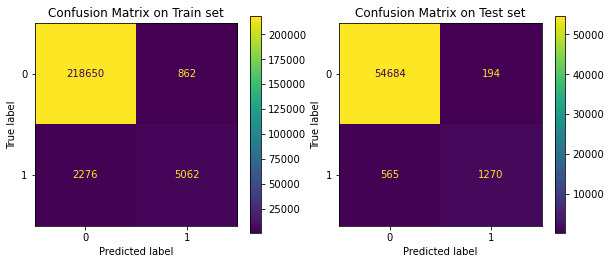

In [10]:
fig , axes = plt.subplots(1, 2, figsize=(10, 4))#, sharey='row')
disp = ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred, ax=axes[0]) 
disp.ax_.set_title('Confusion Matrix on Train set')

disp = ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_pred, ax=axes[1])
disp.ax_.set_title('Confusion Matrix on Test set')

In [13]:
############
# Receiver Operating Characteristic
######
probas_train = classifier.predict_proba(X_train)[:,1]
precisions, recalls, thresholds = roc_curve(Y_train, probas_train)
fig = go.Figure(
    data = go.Scatter(
        name = 'train',
        x = precisions,  
        y = recalls, 
        mode = 'lines'
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "ROC curve", x = 0.5),
        xaxis = go.layout.XAxis(title = 'False Positive Rate'),
        yaxis = go.layout.YAxis(title = 'True Positive Rate')
    )
)
probas_test = classifier.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = roc_curve(Y_test, probas_test)
fig.add_trace(go.Scatter(
    name = 'test',
    x = precisions, 
    y = recalls, 
    mode = 'lines'
    )
)
fig.show()

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [14]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='merror', gamma=0.3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [15]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
#features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, label_num+label_cat]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[28 16 'UK' 0 'Seo']
 [22 5 'UK' 1 'Direct']
 [32 1 'China' 1 'Seo']
 [32 6 'US' 1 'Ads']
 [25 3 'China' 0 'Seo']]


In [16]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
# done with X_train
print("Encoding categorical features and standardizing numerical features...")
X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30636107  3.32629502  0.          1.          0.          0.
   0.          1.        ]
 [-1.04644166  0.03741548  0.          1.          0.          1.
   1.          0.        ]
 [ 0.18702599 -1.15854072  0.          0.          0.          1.
   0.          1.        ]
 [ 0.18702599  0.33640453  0.          0.          1.          1.
   0.          0.        ]
 [-0.67640137 -0.56056262  0.          0.          0.          0.
   0.          1.        ]]


In [58]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_cammarata.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**